# Lending Club Loans Status Prediction - Part 3: Pre-processing and Training Data Development

When one borrower submits a loan application, the lender company will collected many information from him/her, and based on the information collected, they will run their algorithm and try to predict if the customer will be able to or will be willing to fully paid the loans. Then they will either approve or deny the loan application. So the prediction must be as accurate as possible, otherwise the lending companny will either loss business opportunity or loss profit.

In this study, we will use Lending Club's data from kaggle (https://www.kaggle.com/wordsforthewise/lending-club), and build a model to predict the loan's future status. 

This is the third part of the study: Pre-processing & Training Data Development. In this project we would like to manipulate our data as following:

# Contents

# 1. Balance the data
# 2. Evaluation of Model Performance under Different Conditions
## 2.1 K Nearest Neighbors with 4 Most Correlated Features
## 2.2 K Nearest Neighbors with 4 Most Correlated Features (Scaled)
## 2.3 Grid Search Cross Validation for k Value
## 2.4 Random Forest
## 2.5 Logistic Regression
## 2.6 K Nearest Neighbors with 4 Most Correlated Features and 2 Categorical Features
## 2.7 Random Forest with 4 Most Correlated Features and 2 Categorical Features
## 2.8 Random Forest with 6 Most Correlated Features and 2 Categorical Features
## 2.9 Random Forest with 9 Principal Components
# 3. Conclusion and Write Data to File

First let's import modules and read data.

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [323]:
# Read data to the data frame.
data_lc = pd.read_csv('../Data/lending_club_data.csv')

In [324]:
data_lc.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,dti,...,application_type,acc_open_past_24mths,mort_acc,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,disbursement_method,debt_settlement_flag,earliest_cr_line_year
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,1,debt_consolidation,5.91,...,Individual,4.0,1.0,3.0,0.0,178050.0,2400.0,Cash,N,2003
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,1,small_business,16.06,...,Individual,4.0,4.0,2.0,7.7,314017.0,79300.0,Cash,N,1999
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,1,home_improvement,10.78,...,Joint App,6.0,5.0,0.0,50.0,218418.0,6200.0,Cash,N,2000
3,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,1,major_purchase,25.37,...,Individual,10.0,6.0,4.0,60.0,439570.0,20300.0,Cash,N,1998
4,11950.0,36 months,13.44,C,4 years,RENT,34000.0,1,debt_consolidation,10.20,...,Individual,0.0,0.0,0.0,100.0,16900.0,9400.0,Cash,N,1987


In [325]:
data_lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188428 entries, 0 to 1188427
Data columns (total 28 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   loan_amnt              1188428 non-null  float64
 1   term                   1188428 non-null  object 
 2   int_rate               1188428 non-null  float64
 3   grade                  1188428 non-null  object 
 4   emp_length             1188428 non-null  object 
 5   home_ownership         1188428 non-null  object 
 6   annual_inc             1188428 non-null  float64
 7   loan_status            1188428 non-null  int64  
 8   purpose                1188428 non-null  object 
 9   dti                    1188428 non-null  float64
 10  fico_range_high        1188428 non-null  float64
 11  inq_last_6mths         1188428 non-null  float64
 12  revol_util             1188428 non-null  float64
 13  initial_list_status    1188428 non-null  object 
 14  total_rec_late_fee

# 1. Balance the data

Let's count the value of column 'loan status'.

In [326]:
loan_status_count = pd.DataFrame(data_lc['loan_status'].value_counts())

In [327]:
loan_status_count

,loan_status
1,953495
0,234933


In [328]:
print(loan_status_count.loc[1, 'loan_status'] / loan_status_count.loc[0, 'loan_status'] )

4.058582659737032


We see that the amount of data points with loan_status = 1 (fully paid) is about 4 times of the amount of loan_status = 0 (defaulted), which means the data is not balanced. To ensure the high data quality we should try to keep it balanced. Since we have large amount of data, we should reduce the data point with loan_status = 1. We can keep only half of it so that the ratio is about 1.6:1. 

In [329]:
# let's first get all data points of default loans
data_1 = data_lc[data_lc['loan_status']==0]

In [330]:
# this is to get 40% data points of all fully paid loans.
data_2 = data_lc[data_lc['loan_status']==1].sample(frac=0.4)

In [331]:
data_1.shape

(234933, 28)

In [332]:
data_2.shape

(381398, 28)

In [333]:
data_balanced = pd.concat([data_1, data_2], ignore_index=True)

In [334]:
data_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616331 entries, 0 to 616330
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   loan_amnt              616331 non-null  float64
 1   term                   616331 non-null  object 
 2   int_rate               616331 non-null  float64
 3   grade                  616331 non-null  object 
 4   emp_length             616331 non-null  object 
 5   home_ownership         616331 non-null  object 
 6   annual_inc             616331 non-null  float64
 7   loan_status            616331 non-null  int64  
 8   purpose                616331 non-null  object 
 9   dti                    616331 non-null  float64
 10  fico_range_high        616331 non-null  float64
 11  inq_last_6mths         616331 non-null  float64
 12  revol_util             616331 non-null  float64
 13  initial_list_status    616331 non-null  object 
 14  total_rec_late_fee     616331 non-nu

The new data set has 616331 rows, about 52% of total amount of rows in original data.

In [335]:
data_balanced['loan_status'].value_counts()

1    381398
0    234933
Name: loan_status, dtype: int64

# 2. Evaluation of Model Performance under different conditions

We wants to evaluate the performance on a few models, under different conditions, to select the conditions for the model, such as which predictor feature to choose, if we should choose scaling and PCA.

## 2.1 K-neighbors with 4 most correlated features

First let's think of which features should we choose for our model. The criteria is the correlation to our target feature, loan status.

In [336]:
columns_numerical = data_balanced.select_dtypes(['float','int64']).columns

In [337]:
columns_numerical

Index(['loan_amnt', 'int_rate', 'annual_inc', 'loan_status', 'dti',
       'fico_range_high', 'inq_last_6mths', 'revol_util', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_low',
       'acc_open_past_24mths', 'mort_acc', 'num_tl_op_past_12m',
       'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit',
       'earliest_cr_line_year'],
      dtype='object')

In [338]:
col_corr = []
data_corr = []
for item in columns_numerical:
    data_corr.append(abs(data_balanced['loan_status'].corr(data_balanced[item])))
    col_corr.append(item)
    
df_corr = pd.DataFrame({'column':col_corr, 'correlation':data_corr})
df_corr.sort_values('correlation')

,column,correlation
2,annual_inc,0.047058
18,earliest_cr_line_year,0.061175
7,revol_util,0.071629
15,percent_bc_gt_75,0.081630
6,inq_last_6mths,0.082099
0,loan_amnt,0.085216
17,total_bc_limit,0.088721
13,mort_acc,0.093250
16,tot_hi_cred_lim,0.096132
14,num_tl_op_past_12m,0.106615


We can see that columns 'last_fico_range_low', 'recoveries', 'last_pymnt_amnt', and 'int_rate' have the highest correlation with loan status. So we would like to use them as predictor features and evaluate the K neighbors model.

In [339]:
# define predictor features
cols_model = ['last_fico_range_low', 'recoveries', 'last_pymnt_amnt', 'int_rate']

In [340]:
X = data_balanced[cols_model]

In [341]:
X.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate
0,580.0,1618.90,471.70,19.48
1,0.0,368.37,146.16,14.85
2,625.0,0.00,565.09,12.88
3,0.0,0.00,701.01,24.24
4,600.0,0.00,581.58,13.99


In [342]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616331 entries, 0 to 616330
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   last_fico_range_low  616331 non-null  float64
 1   recoveries           616331 non-null  float64
 2   last_pymnt_amnt      616331 non-null  float64
 3   int_rate             616331 non-null  float64
dtypes: float64(4)
memory usage: 18.8 MB


In [343]:
y = data_balanced['loan_status']

In [344]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21)

In [345]:
# define the KNN model
knn_1 = KNeighborsClassifier(n_neighbors=5)

In [346]:
# fit the model with the train data
knn_1.fit(X_train, y_train)

KNeighborsClassifier()

In [347]:
y_pred = knn_1.predict(X_test)

In [348]:
score_1 = knn_1.score(X_test, y_test)

In [349]:
print(score_1)

0.9560561515546816


In [350]:
print(confusion_matrix(y_test, y_pred))

[[55136  3416]
 [ 3355 92176]]


In [351]:
classification_report_1 = classification_report(y_test, y_pred, digits = 3, output_dict=True)

In [352]:
print(classification_report(y_test, y_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.943     0.942     0.942     58552
           1      0.964     0.965     0.965     95531

    accuracy                          0.956    154083
   macro avg      0.953     0.953     0.953    154083
weighted avg      0.956     0.956     0.956    154083



In [353]:
X.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate
0,580.0,1618.90,471.70,19.48
1,0.0,368.37,146.16,14.85
2,625.0,0.00,565.09,12.88
3,0.0,0.00,701.01,24.24
4,600.0,0.00,581.58,13.99


#### Conclusion: From the study above, we can see that the score for the case with 4 most correlated features is 0.956, and the classification report is shown above. This gives us a bottom line and we will use it as reference to evaluate other models. 

## 2.2 K neighbors with 4 most correlated features (scaled)

In this model, we will still use K neighbors and the 4 features same as model 2.1. But in this model we will scale the 4 features. The reason is to see if the model performance will improve after the scaling.

In [354]:
from sklearn.preprocessing import scale, StandardScaler

In [355]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, random_state = 21)

In [356]:
scaler = StandardScaler()

In [357]:
X_tr_scaled = scaler.fit_transform(X1_train)

In [358]:
X_te_scaled = scaler.transform(X1_test)

In [359]:
knn_2 = KNeighborsClassifier(n_neighbors=5)

In [360]:
knn_2.fit(X_tr_scaled, y1_train)

KNeighborsClassifier()

In [361]:
y1_pred = knn_2.predict(X_te_scaled)

In [362]:
score_2 = knn_2.score(X_te_scaled, y1_test)

In [363]:
print(classification_report(y1_test, y1_pred, digits=3))

              precision    recall  f1-score   support

           0      0.940     0.942     0.941     58552
           1      0.965     0.963     0.964     95531

    accuracy                          0.955    154083
   macro avg      0.952     0.953     0.953    154083
weighted avg      0.955     0.955     0.955    154083



In [364]:
classification_report_2 = classification_report(y1_test, y1_pred, digits=3, output_dict=True)

In [365]:
print('Score before scaling:', round(score_1, 3), '  Score after scaling:', round(score_2,3))

Score before scaling: 0.956   Score after scaling: 0.955


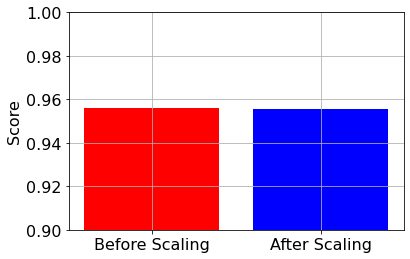

In [366]:
plt.bar(['Before Scaling','After Scaling'], [score_1, score_2], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [367]:
report_1 = pd.DataFrame(classification_report_1)

In [368]:
report_2 = pd.DataFrame(classification_report_2)

In [369]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_2.loc['f1-score','0'], report_2.loc['f1-score','1']]

In [370]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Scaled/Original':['Original', 'Original', 'Scaled', 'Scaled'], 'f1 score':f1_score_value})

In [371]:
f1_score_df

,loan_status,Scaled/Original,f1 score
0,0,Original,0.942149
1,1,Original,0.964573
2,0,Scaled,0.941322
3,1,Scaled,0.963972


In [372]:
plt.rc('font', size=16)

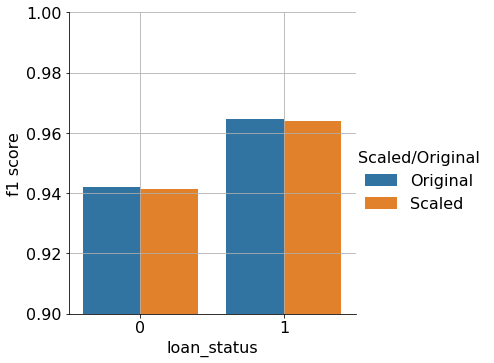

In [373]:
sns.catplot(x='loan_status', y='f1 score', data=f1_score_df, hue='Scaled/Original', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

In [374]:
X.describe()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate
count,616331.000000,616331.000000,616331.000000,616331.000000
mean,624.031211,481.829520,4471.510661,13.831898
std,162.005326,1311.266992,6736.314749,4.944392
min,0.000000,0.000000,0.000000,5.310000
25%,570.000000,0.000000,348.270000,10.410000
50%,665.000000,0.000000,825.560000,13.330000
75%,715.000000,75.000000,6378.100000,16.990000
max,845.000000,39859.550000,41453.070000,30.990000


#### Conclusion: From the two plots above, we can see that after the scaling, there is almost no improvment in both scole (accuracy) and the f1 score. Therefore we get the conclusion that the scaling is not needed for this case. So we will not do scaling for the K neighbors models. 

## 2.3 Grid Search Cross Validation for k value

In our previous analysis we use k value(n_neighbors) to be 5. This is just our intuitive guess. We wants to use cross validation to find the best value. We just want to test a few values as (3, 5, 7, 9) 

In [375]:
from sklearn.model_selection import GridSearchCV

In [376]:
param_grid = {'n_neighbors': np.arange(3,10,2)}

In [377]:
knn_model = KNeighborsClassifier()

In [378]:
knn_cv = GridSearchCV(knn_model, param_grid, cv=5)

In [379]:
knn_cv.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([3, 5, 7, 9])})

In [380]:
knn_cv.best_params_

{'n_neighbors': 9}

In [381]:
knn_cv.best_score_

0.9574222214517043

#### Conclusion: Result shows that the best n_neighbors value is 9.

## 2.4 Random Forest

Now Let's try the random forest model and see what is the performance.

In [382]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [383]:
RFModel = RandomForestClassifier(random_state = 123)

# Model and fit
RFModel.fit(X_train, y_train)
y_pred_rf = RFModel.predict(X_test)

In [384]:
score_3 = RFModel.score(X_test, y_test)

In [385]:
print(classification_report(y_test, y_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.948     0.952     0.950     58552
           1      0.970     0.968     0.969     95531

    accuracy                          0.962    154083
   macro avg      0.959     0.960     0.960    154083
weighted avg      0.962     0.962     0.962    154083



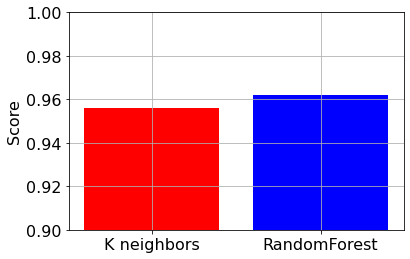

In [386]:
plt.bar(['K neighbors','RandomForest'], [score_1, score_3], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [387]:
classification_report_3 = classification_report(y_test, y_pred_rf, digits=3, output_dict=True)

In [388]:
report_3 = pd.DataFrame(classification_report_3)

In [389]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_3.loc['f1-score','0'], report_3.loc['f1-score','1']]

In [390]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['KNN', 'KNN', 'RandomForest', 'RandomForest'], 'f1_score':f1_score_value})

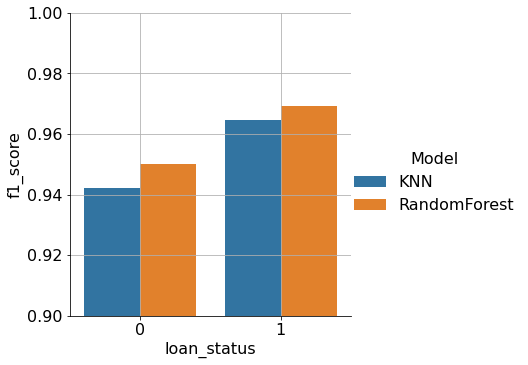

In [391]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: Results show that the random forest model DOES improve the performance. So far it is the best model among all.

## 2.5 Logistic Regression

We want to try logistic regression as our next model.

In [392]:
from sklearn.linear_model import LogisticRegression

In [393]:
logreg = LogisticRegression()

In [394]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [395]:
y_pred_lr = logreg.predict(X_test)

In [396]:
score_4 = logreg.score(X_test, y_test)

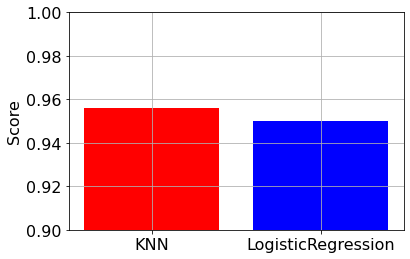

In [397]:
plt.bar(['KNN','LogisticRegression'], [score_1, score_4], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [398]:
classification_report_4 = classification_report(y_test, y_pred_lr, digits=3, output_dict=True)

In [399]:
report_4 = pd.DataFrame(classification_report_4)

In [400]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_4.loc['f1-score','0'], report_4.loc['f1-score','1']]

In [401]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['KNN', 'KNN', 'LogisticRegression', 'LogisticRegression'], 'f1_score':f1_score_value})

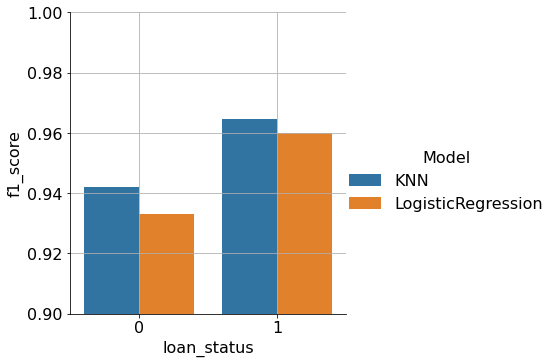

In [402]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: The logistic regression is fast but the result is not as good as the K neighbors model.

## 2.6 K Neighbors with 4 most correlated features and 2 categorical features

We want to see the influence of those categorical featuers. So we would like to include the two categorical features in our model. 

In [403]:
cols_for_model = ['last_fico_range_low', 'recoveries', 'last_pymnt_amnt', 'int_rate','term', 'debt_settlement_flag']

In [404]:
X_new = data_balanced[cols_for_model]

In [405]:
X_new.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate,term,debt_settlement_flag
0,580.0,1618.90,471.70,19.48,60 months,N
1,0.0,368.37,146.16,14.85,36 months,N
2,625.0,0.00,565.09,12.88,36 months,N
3,0.0,0.00,701.01,24.24,60 months,N
4,600.0,0.00,581.58,13.99,60 months,N


In [406]:
X_new = pd.get_dummies(X_new, drop_first=True)

In [407]:
X_new.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate,term_ 60 months,debt_settlement_flag_Y
0,580.0,1618.90,471.70,19.48,1,0
1,0.0,368.37,146.16,14.85,0,0
2,625.0,0.00,565.09,12.88,0,0
3,0.0,0.00,701.01,24.24,1,0
4,600.0,0.00,581.58,13.99,1,0


In [408]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_new, y, random_state = 21)

In [409]:
knn_n = KNeighborsClassifier(n_neighbors=9)

In [410]:
knn_n.fit(Xn_train, yn_train)

KNeighborsClassifier(n_neighbors=9)

In [411]:
yn_pred = knn_n.predict(Xn_test)

In [412]:
score_5 = knn_n.score(Xn_test, yn_test)

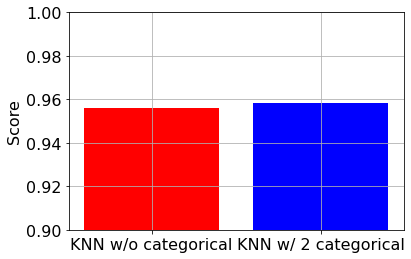

In [413]:
plt.bar(['KNN w/o categorical','KNN w/ 2 categorical'], [score_1, score_5], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [414]:
classification_report_5 = classification_report(y_test, yn_pred, digits=3, output_dict=True)

In [415]:
report_5 = pd.DataFrame(classification_report_5)

In [416]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_5.loc['f1-score','0'], 
                  report_5.loc['f1-score','1']]

In [417]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['K neighbors w/o categorical', 
        'K neighbors w/o categorical', 'K neighbors w/ 2 categorical', 'K neighbors w/ 2 categorical'], 
                'f1_score':f1_score_value})

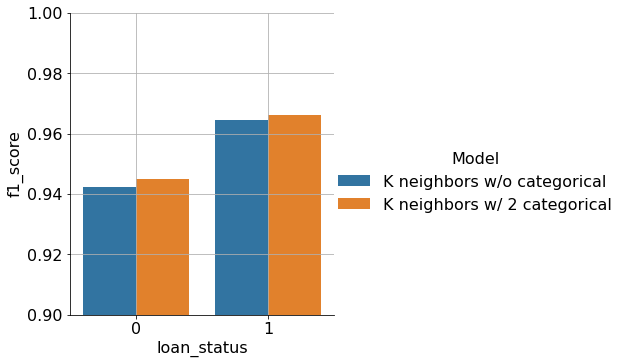

In [418]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: We do see that after the two categorical features included, the model performance was improved.

## 2.7 Random Forest with 4 most correlated features and 2 categorical features

In [419]:
NewRFModel = RandomForestClassifier(random_state = 123)

# Model and fit
NewRFModel.fit(Xn_train, yn_train)
yn_pred_rf = NewRFModel.predict(Xn_test)

In [420]:
score_6 = NewRFModel.score(Xn_test, yn_test)

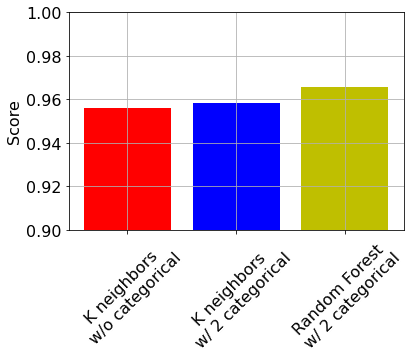

In [421]:
plt.bar(['K neighbors\n w/o categorical','K neighbors\n w/ 2 categorical', 'Random Forest\n w/ 2 categorical'], 
        [score_1, score_5,score_6], color=['r', 'b', 'y'])
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [422]:
print(classification_report(yn_test, yn_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.954     0.956     0.955     58552
           1      0.973     0.972     0.972     95531

    accuracy                          0.966    154083
   macro avg      0.963     0.964     0.964    154083
weighted avg      0.966     0.966     0.966    154083



In [423]:
classification_report_6 = classification_report(y_test, yn_pred_rf, digits=3, output_dict=True)

In [424]:
report_6 = pd.DataFrame(classification_report_6)

In [425]:
f1_score_value = [report_1.loc['f1-score','0'], report_1.loc['f1-score','1'], report_5.loc['f1-score','0'], 
                  report_5.loc['f1-score','1'], report_6.loc['f1-score','0'], report_6.loc['f1-score','1']]

In [426]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1,0,1], 'Model':['KNN w/o cat', 'KNN w/o cat', 'KNN w/ 2 cat', 
        'KNN w/ 2 cat','RandmFrst w/ 2 categorical','RandmFrst w/ 2 categorical'], 'f1_score':f1_score_value})

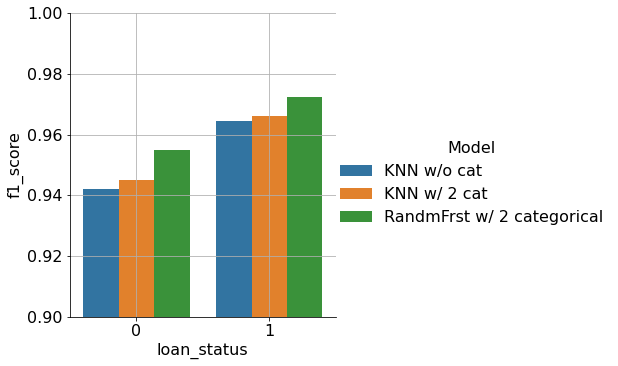

In [427]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

#### Conclusion: Based on the comparason of all three models, we can see that the random forest model with 4 numerical features and two categorical features are much better than the other two.

## 2.8 Random Forest with 6 most correlated features and 2 categorical features

In [428]:
col2_for_model = ['last_fico_range_low', 'recoveries', 'last_pymnt_amnt', 'int_rate', 'term',
                  'debt_settlement_flag', 'fico_range_high', 'total_rec_late_fee']

In [429]:
X3 = data_balanced[col2_for_model]

In [430]:
X3.head()

,last_fico_range_low,recoveries,last_pymnt_amnt,int_rate,term,debt_settlement_flag,fico_range_high,total_rec_late_fee
0,580.0,1618.90,471.70,19.48,60 months,N,669.0,0.00
1,0.0,368.37,146.16,14.85,36 months,N,729.0,0.00
2,625.0,0.00,565.09,12.88,36 months,N,679.0,161.46
3,0.0,0.00,701.01,24.24,60 months,N,664.0,0.00
4,600.0,0.00,581.58,13.99,60 months,N,734.0,0.00


In [431]:
X3 = pd.get_dummies(X3, drop_first=True)

In [432]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, random_state = 21)

In [433]:
NewRFModel3 = RandomForestClassifier(random_state = 123)

# Model and fit
NewRFModel3.fit(X_train, y_train)
y_pred_rf = NewRFModel3.predict(X_test)

In [434]:
score_7 = NewRFModel3.score(X_test, y_test)

In [435]:
score_6, score_7

(0.9656159342691926, 0.9669918160991154)

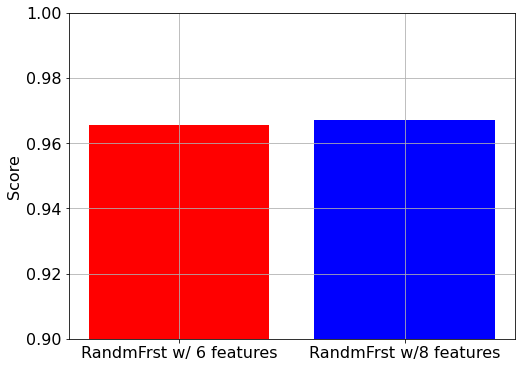

In [436]:
plt.figure(figsize=(8,6))
plt.bar(['RandmFrst w/ 6 features','RandmFrst w/8 features'], [score_6, score_7], color=['r', 'b'])
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.ylabel('Score')
plt.show()

In [437]:
classification_report_7 = classification_report(y_test, y_pred_rf, digits=3, output_dict=True)

In [438]:
print(classification_report(y_test, y_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.955     0.958     0.957     58552
           1      0.974     0.972     0.973     95531

    accuracy                          0.967    154083
   macro avg      0.965     0.965     0.965    154083
weighted avg      0.967     0.967     0.967    154083



In [439]:
report_7 = pd.DataFrame(classification_report_7)

In [440]:
f1_score_value = [report_6.loc['f1-score','0'], report_6.loc['f1-score','1'], report_7.loc['f1-score','0'], 
                  report_7.loc['f1-score','1']]

In [441]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['RandmFrst w/ 6 features', 'RandmFrst w/ 6 features', 
                                'RandmFrst w/ 8 features', 'RandmFrst w/ 8 features'], 'f1_score':f1_score_value})

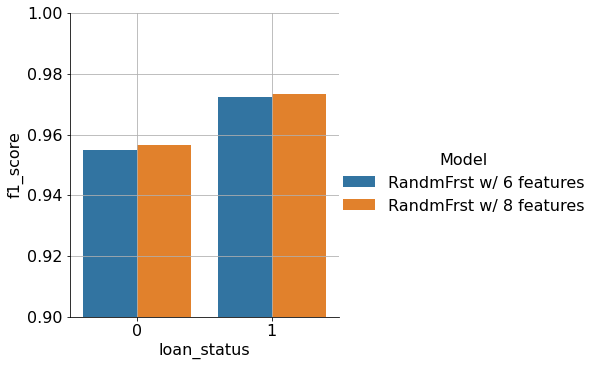

In [442]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.9, 1.0)
plt.grid(True)
plt.show()

In [443]:
print(confusion_matrix(y_test, y_pred_rf))

[[56102  2450]
 [ 2636 92895]]


Let's then have a look at the ROC curve and AUC score.

In [444]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [445]:
y_pred_prob = NewRFModel3.predict_proba(X_test)[:,1]

In [446]:
y_pred_prob

array([1.  , 1.  , 0.27, ..., 1.  , 1.  , 0.04])

In [447]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

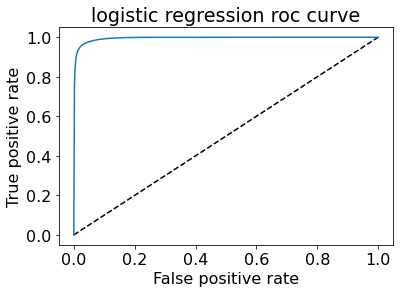

In [448]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'logistic regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('logistic regression roc curve')
plt.show()

In [449]:
cv_results = cross_val_score(NewRFModel3, X3, y, cv=5)

In [450]:
roc_auc_score(y_test, y_pred_prob)

0.9947230394523637

In [451]:
cv_scores = cross_val_score(NewRFModel3, X3, y, cv=5, scoring='roc_auc')

In [452]:
print('cv_results:',cv_results, ' cv_score', cv_scores)

cv_results: [0.96664152 0.96638976 0.96510798 0.96388298 0.97034056]  cv_score [0.99436905 0.99442073 0.99381699 0.99383358 0.9953699 ]


Let's do the grid search cross validation for the best parameter and best score.

In [453]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [454]:
param_grid = {'n_estimators':np.arange(55,65)}
rfc = RandomForestClassifier()
rf_cv= GridSearchCV(rfc, param_grid, cv=5)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64])})

In [455]:
rf_cv.best_params_

{'n_estimators': 56}

In [456]:
rf_cv.best_score_

0.9676147904001867

#### Conclusion: The model of random forest with six most correlated features and two categorical features slightly improve the performance (0.2% higher in the f1 score). Therefore we will use this one as our final model (random forest with 6 most correlated and 2 categorical).

## 2.9 Random Forest with 9 Principal Components

Let's have a look on the effect of Principal Components Analysis (PCA).

In [457]:
y = data_lc['loan_status']

In [458]:
# encoding the predictor variables
X_encoding = pd.get_dummies(data_lc.drop(columns='loan_status'), drop_first = True)

In [459]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_encoding, y, random_state = 21)

In [460]:
scaler = StandardScaler()

In [461]:
# scale the data
X_tr_sc = scaler.fit_transform(X1_train) 

In [462]:
# transform test data
X_te_sc = scaler.transform(X1_test)

In [463]:
from sklearn.decomposition import PCA
pca = PCA(n_components=9)

In [464]:
# fit and transform the training data
X_tr_pca = pca.fit_transform(X_tr_sc)

In [465]:
# transform the test data
X_te_pca = pca.transform(X_te_sc)

In [466]:
NewRFModel4 = RandomForestClassifier(random_state = 123)

# Model and fit
NewRFModel4.fit(X_tr_pca, y1_train)
y_pre = NewRFModel4.predict(X_te_pca)

In [467]:
print(classification_report(y1_test, y_pre, digits=3))

              precision    recall  f1-score   support

           0      0.906     0.795     0.847     58767
           1      0.951     0.980     0.965    238340

    accuracy                          0.943    297107
   macro avg      0.929     0.888     0.906    297107
weighted avg      0.942     0.943     0.942    297107



In [468]:
classification_report_8 = classification_report(y1_test, y_pre, digits=3, output_dict=True)

In [469]:
report_8 = pd.DataFrame(classification_report_8)

In [470]:
f1_score_value = [report_7.loc['f1-score','0'], report_7.loc['f1-score','1'], report_8.loc['f1-score','0'], 
                  report_8.loc['f1-score','1']]

In [471]:
f1_score_df =pd.DataFrame({'loan_status':[0,1,0,1], 'Model':['RandmFrst w/ 8 features', 'RandmFrst w/ 8 features', 
                                'RandmFrst w/ 9 PCs', 'RandmFrst w/ 9 PCs'], 'f1_score':f1_score_value})

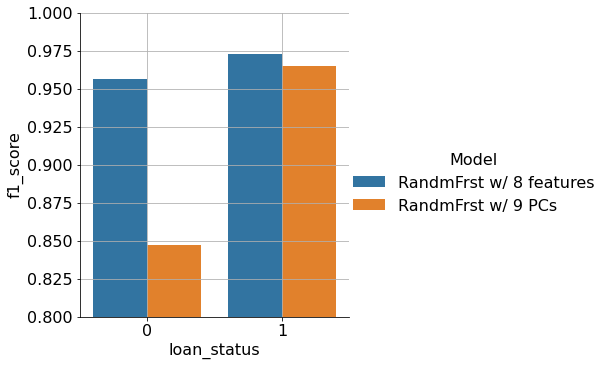

In [472]:
sns.catplot(x='loan_status', y='f1_score', data=f1_score_df, hue='Model', kind='bar')
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.show()

Result shows that the random forest gives a bad score in predicting default loans. So we will not use it in our final model. 

# 3. Conclusion and Write Data to File

In [473]:
cols_for_model_final = ['last_fico_range_low', 'recoveries', 'last_pymnt_amnt', 'int_rate', 'term', 'loan_status',
                  'debt_settlement_flag', 'fico_range_high', 'total_rec_late_fee']

In [474]:
# write balanced data to file.
file_name = '../Data/lending_club_data_balanced.csv'
data_balanced[cols_for_model_final].to_csv(file_name, index=False)

## Final Conclusion: In this study, first we balanced the data by dropping 60% of data points of fully paid loans. Then we run a few models and evaluate their performances. We also test the data scaling and PCA. Both the scaling and PCA do not give a satisfying result so we will not use them in the final model. We have selected eight features for our final modeling. 